<a href="https://colab.research.google.com/github/SAR-bang/RecommenderSystem/blob/main/Recommendaersystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [155]:
# from google.colab import files
# data_to_load = files.upload()

In [156]:
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from scipy import sparse
raw  = pd.read_csv("post_data.csv")
df = raw
df = df.rename(columns={"Valuable ":"rating"})

In [157]:
feed = df.groupby('user_id')
feed.groups
feed.count()

,post_id,time_stamp,rating
user_id,,,
5eece14efc13ae6609000000,41,41,41
5eece14efc13ae6609000001,177,177,177
5eece14efc13ae6609000002,2,2,2
5eece14efc13ae6609000003,156,156,156
5eece14efc13ae6609000004,104,104,104
...,...,...,...
5eece14ffc13ae66090001ef,182,182,182
5eece14ffc13ae66090001f0,248,248,248
5eece14ffc13ae66090001f1,120,120,120


In [158]:
feed.nunique()

,post_id,time_stamp,rating
user_id,,,
5eece14efc13ae6609000000,41,41,5
5eece14efc13ae6609000001,176,177,5
5eece14efc13ae6609000002,2,2,2
5eece14efc13ae6609000003,152,156,5
5eece14efc13ae6609000004,103,104,5
...,...,...,...
5eece14ffc13ae66090001ef,180,182,5
5eece14ffc13ae66090001f0,245,248,5
5eece14ffc13ae66090001f1,119,120,5


In [159]:
df.isnull().sum() # finds null value in each column

user_id       0
post_id       0
time_stamp    0
rating        0
dtype: int64

In [160]:
df.dropna(inplace=True)

In [161]:
df.isnull().sum()

user_id       0
post_id       0
time_stamp    0
rating        0
dtype: int64

In [162]:
# mapping the values to 0 and 1 assuming values between1,2 and 3,4,5

df['rating']= df['rating'].map({1:0,2:0,3:1,4:1,5:1})
users = df['user_id'].unique()

# df['user_id']= users.index

In [163]:
# embeddings = range(0,users)
users = list(users)

In [164]:
users_series = pd.Series(df['user_id'].unique())
index = users_series.index
# index.map(users_series)
for  i in range(df['user_id'].nunique()):
  df['user_id'] = df['user_id'].replace(users[i],i)



In [165]:
# creating a new  df for UIR (user item ratings)
# s1 = df['user_id']
# s2 = df['post_id']
# s3 = df['rating']
# left = pd.DataFrame([s3],index=[s1])

# right = pd.DataFrame([s3],index=[s2])

In [166]:
percent = int(len(df)*0.8)
train_data = df[:percent]
test_data = df[percent:]

In [167]:
no_rated_post_per_user = train_data.groupby(by="user_id")["rating"].count().sort_values(ascending=False)
no_rated_post_per_user.head()

user_id
197    250
231    240
58     240
84     240
355    238
Name: rating, dtype: int64

In [168]:
no_ratings_per_post = train_data.groupby(by = "post_id")["rating"].count().sort_values(ascending = False)
no_ratings_per_post.head()

post_id
612931747    22
617669758    21
429516537    21
573552524    21
177312133    21
Name: rating, dtype: int64

In [169]:
def get_user_item_sparse_matrix(df):
    sparse_data = sparse.csr_matrix((df.rating, (df.user_id, df.post_id)))
    return type(df.rating)
# get_user_item_sparse_matrix(train_data)
df['rating'] = pd.to_numeric(df['rating'])
df['post_id'] = pd.to_numeric(df['post_id'])
# df['user_id'] = pd.to_numeric(df['user_id'])

In [170]:
def build_rating_sparse_tensor(ratings_df):
  return tf.SparseTensor(
      indices=ratings_df[['user_id','post_id']].values,
      values=ratings_df['rating'].values,
      dense_shape=[df.shape[0], df.shape[0]])

In [171]:
df.shape

(71800, 4)

In [172]:
del df['time_stamp']


In [173]:
import tensorflow as tf

train_sparse_data = build_rating_sparse_tensor(train_data)
test_sparse_data = build_rating_sparse_tensor(test_data)



In [174]:
df.groupby('post_id')['rating'].mean().sort_values(ascending=False)

post_id
424361005    1.000000
350131217    1.000000
452656962    1.000000
963345306    1.000000
444036396    1.000000
               ...   
634786750    0.100000
247297198    0.090909
874539541    0.000000
784948469    0.000000
331207927    0.000000
Name: rating, Length: 6000, dtype: float64

In [175]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, movie_embeddings):
  predictions = tf.gather_nd(
      tf.matmul(user_embeddings, movie_embeddings, transpose_b=True),
      sparse_ratings.indices)
  loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
  return loss

In [176]:
ratings = pd.DataFrame(df.groupby('post_id')['rating'].mean())
ratings['num of ratings'] = pd.DataFrame(df.groupby('post_id')['rating'].count())
ratings.head()

,rating,num of ratings
post_id,,
10109921,0.571429,14
10164988,0.588235,17
10256424,0.500000,6
10260109,0.500000,6
10467477,0.428571,7


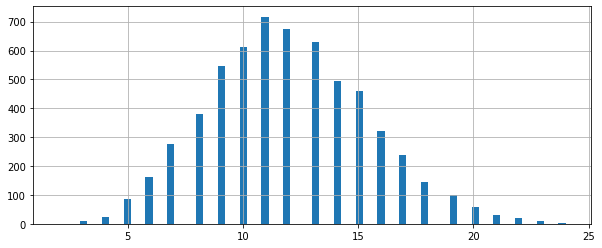

In [177]:
plt.figure(figsize=(10,4))
ratings['num of ratings'].hist(bins=70)

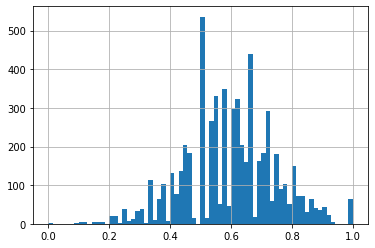

In [178]:
ratings['rating'].hist(bins=70)

In [179]:
post_mat = df.pivot_table(index='user_id',columns='post_id',values='rating')
# post_mat = post_mat.fillna(0)
ratings.sort_values('num of ratings', ascending = False).head(10) 


,rating,num of ratings
post_id,,
926110568,0.708333,24
805157710,0.541667,24
177312133,0.500000,24
55715945,0.416667,24
61669231,0.869565,23
41361372,0.608696,23
617669758,0.782609,23
408118198,0.695652,23
94111361,0.608696,23


In [180]:
test_ratings = post_mat[612931747]
test2_ratings = post_mat[41361372	]

In [181]:
similar_to_post1 = post_mat.corrwith(test_ratings)
corr_post1 = pd.DataFrame(similar_to_post1,columns=['Correlation'])
corr_post1.dropna(inplace=True)
corr_post1

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,Correlation
post_id,
10977171,0.866025
13766583,1.000000
15166848,-1.000000
16181605,-0.500000
17656010,1.000000
...,...
986648213,1.000000
988187942,-1.000000
990469647,1.000000


In [ ]:
corr_post1.sort_values('Correlation',ascending=False).head()
corr_post1 = corr_post1.join(ratings['num of ratings'])
corr_post1.head()
# sorting 


In [191]:
corr_post1[corr_post1['num of ratings']>10].sort_values('Correlation', ascending = False).head(20) 

,Correlation,num of ratings
post_id,,
352196548,1.0,15
851647505,1.0,15
474858331,1.0,11
408118198,1.0,23
497232331,1.0,15
796016985,1.0,11
548853287,1.0,15
540927384,1.0,13
190438362,1.0,15
